In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import kruskal
from sklearn.pipeline import Pipeline



# Wczytanie danych
X_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train_labels.txt', header=None)
X_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test_labels.txt', header=None)

# Połączenie features z etykietami
data = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)
data_all = pd.concat([data, data_test], axis=0)
features = [f'feature_{i}' for i in range(561)]
data_all.columns = [*features, 'label']

data = data_all
print("Kształt danych:", data_all.shape)
print("\nRozkład klas:")
print(data['label'].value_counts())


C:\Users\wista\AppData\Local\Temp\ipykernel_11316\1189924134.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_train.txt', delim_whitespace=True, header=None)
C:\Users\wista\AppData\Local\Temp\ipykernel_11316\1189924134.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('Samsung_HAR/samsung_HAR/samsung_test.txt', delim_whitespace=True, header=None)


Kształt danych: (10299, 562)

Rozkład klas:
label
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


In [2]:
# Funkcja do oceny jakości klastrów
def evaluate_clustering(X, labels_true, labels_pred):
    silhouette = silhouette_score(X, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    return silhouette, ari

# Funkcja do tworzenia wykresów
def plot_clustering_results(X_2d, true_labels, pred_labels, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prawdziwe etykiety
    scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels, cmap='tab10')
    ax1.set_title('Prawdziwe klasy')
    ax1.legend(*scatter1.legend_elements(), title="Klasy")
    
    # Przewidziane klastry
    scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=pred_labels, cmap='tab10')
    ax2.set_title(f'Wyniki {title}')
    ax2.legend(*scatter2.legend_elements(), title="Klastry")
    
    plt.tight_layout()
    plt.show()

# 1. K-means
def kmeans_analysis(X, y_true, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_pred = kmeans.fit_predict(X)
    silhouette, ari = evaluate_clustering(X, y_true, labels_pred)
    return labels_pred, silhouette, ari

# 2. DBSCAN
def dbscan_analysis(X, y_true, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels_pred = dbscan.fit_predict(X)
    # Pomijamy punkty oznaczone jako szum (-1) przy obliczaniu metryk
    mask = labels_pred != -1

     # Sprawdzamy liczbę unikalnych klastrów (bez szumu -1)
    n_clusters = len(np.unique(labels_pred[mask]))
    
    if sum(mask) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X[mask], labels_pred[mask])
        ari = adjusted_rand_score(y_true[mask], labels_pred[mask])
    else:
        silhouette, ari = 0, 0
    return labels_pred, silhouette, ari

# 3. Gaussian Mixture Model
def gmm_analysis(X, y_true, n_components=6):
    gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type='full', n_init=15)
    labels_pred = gmm.fit_predict(X)
    silhouette, ari = evaluate_clustering(X, y_true, labels_pred)
    return labels_pred, silhouette, ari

# 4. K-fold cross validation dla K-means
def kmeans_kfold(X, y, n_splits=5, n_clusters=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        labels_pred = kmeans.predict(X_val)
        
        silhouette = silhouette_score(X_val, labels_pred)
        ari = adjusted_rand_score(y_val, labels_pred)
        scores.append((silhouette, ari))
    
    return labels_pred, silhouette, ari


# Przygotwanie danych

In [3]:
# Obliczenie różnych metryk dla każdej cechy
def calculate_separation_metrics(data, features, y):
    metrics = {}
    
    # 1. Mutual Information - pokazuje jak dobrze cecha przewiduje klasę
    mi_scores = mutual_info_classif(data[features], y)
    
    # 2. Stosunek wariancji między grupami do wariancji wewnątrz grup (F-score)
    f_scores = {}
    for feature in features:
        groups = [data[data['label'] == label][feature].values 
                 for label in np.unique(y)]
        
        # Wariancja między grupami
        means_per_group = [np.mean(g) for g in groups]
        overall_mean = np.mean(data[feature])
        between_var = np.sum([(len(g) * (m - overall_mean)**2) 
                             for g, m in zip(groups, means_per_group)])
        
        # Wariancja wewnątrz grup
        within_var = np.sum([np.sum((g - m)**2) 
                            for g, m in zip(groups, means_per_group)])
        
        if within_var != 0:
            f_scores[feature] = between_var / within_var
        else:
            f_scores[feature] = 0
    
    # 3. Test Kruskala-Wallisa - sprawdza różnice w rozkładach między grupami
    kw_scores = {}
    for feature in features:
        groups = [data[data['label'] == label][feature].values 
                 for label in np.unique(y)]
        statistic, _ = kruskal(*groups)
        kw_scores[feature] = statistic
    
    # Normalizacja wszystkich metryk do przedziału [0,1]
    mi_normalized = (mi_scores - np.min(mi_scores)) / (np.max(mi_scores) - np.min(mi_scores))
    f_normalized = pd.Series(f_scores)
    f_normalized = (f_normalized - f_normalized.min()) / (f_normalized.max() - f_normalized.min())
    kw_normalized = pd.Series(kw_scores)
    kw_normalized = (kw_normalized - kw_normalized.min()) / (kw_normalized.max() - kw_normalized.min())
    
    # Połączenie wszystkich metryk w jeden wynik
    final_scores = (0.4 * mi_normalized + 
                   0.5 * f_normalized + 
                   0.1 * kw_normalized)
    
    return pd.Series(final_scores, index=features)


# # Przygotowanie danych
# X = data.iloc[:, :-1].values  # wszystkie cechy oprócz etykiety
y = data['label'].values

# Obliczenie metryk separacji
separation_scores = calculate_separation_metrics(data, features, y)

# Wybór najlepszych cech
top_features = separation_scores.sort_values(ascending=False).head(100)
print("\nNajlepsze cechy do rozdzielenia kategorii:")
print(top_features)

# Utworzenie nowego zbioru danych z wybranymi cechami
X_selected = data[top_features.index]


Najlepsze cechy do rozdzielenia kategorii:
feature_366    0.903503
feature_52     0.831212
feature_40     0.777394
feature_9      0.771568
feature_367    0.759739
                 ...   
feature_284    0.500795
feature_182    0.500777
feature_536    0.500770
feature_438    0.500312
feature_364    0.499643
Length: 100, dtype: float64


In [4]:
# # Normalizacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


# # Redukcja wymiarowości do 2D dla wizualizacji
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


# Przeprowadzenie analiz

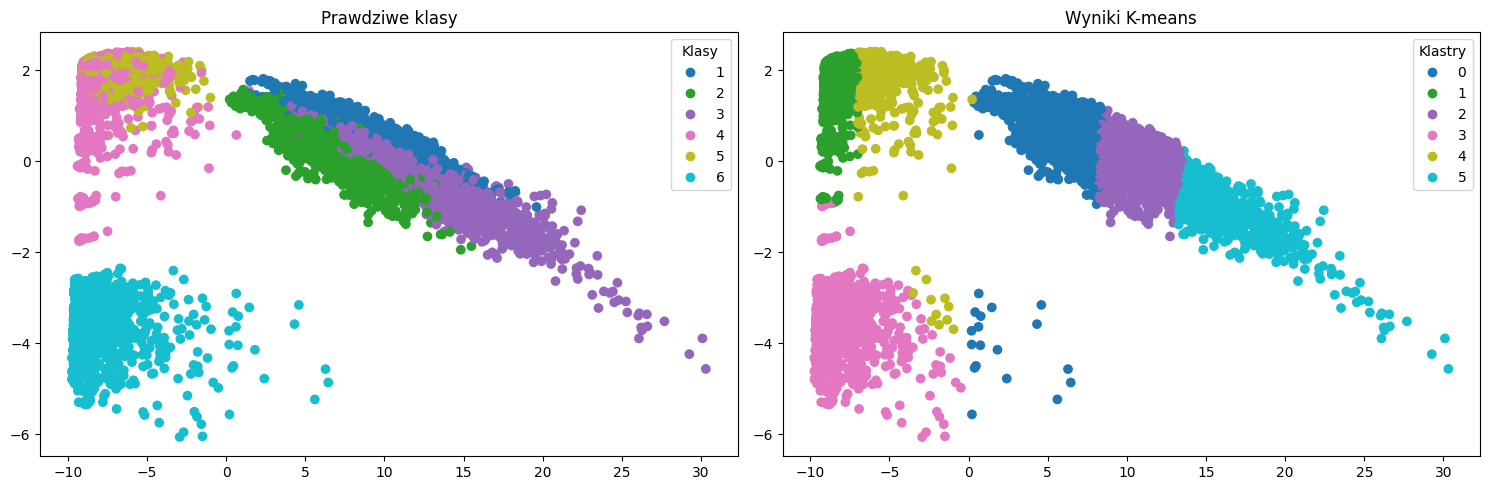

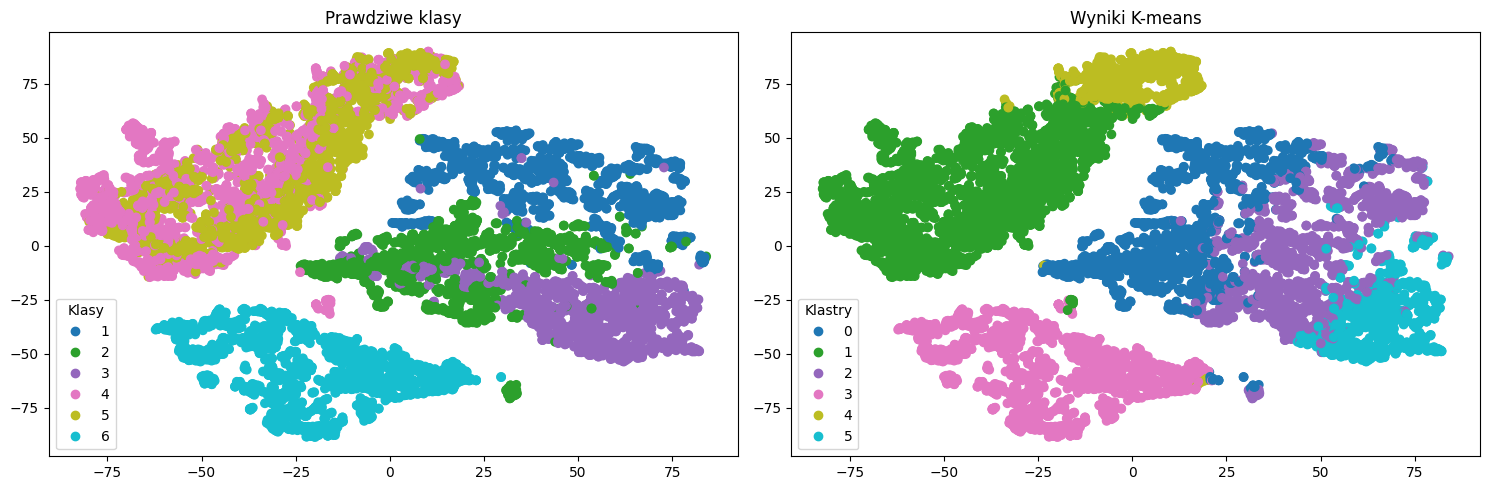

In [5]:
pipe = Pipeline([
  ('scaler', StandardScaler()),
  ('pca', PCA(n_components=2)),
  ('kmeans', KMeans(n_clusters=6))
])

pipe.fit(X_selected)
pred = pipe.predict(X_selected)

plot_clustering_results(X_pca, y, pred, "K-means")
plot_clustering_results(X_tsne, y, pred, "K-means")

# kmeans_labels, kmeans_silhouette, kmeans_ari = kmeans_analysis(X_selected, y, n_clusters=6)
# print(f"Wizualizacja wyników K-means dla n_clusters = {6} (PCA)")
# plot_clustering_results(X_pca, y, kmeans_labels, "K-means")
# print(f"Wizualizacja wyników K-means dla n_clusters = {6} (T-SNE)")
# plot_clustering_results(X_tsne, y, kmeans_labels, "K-means")
# print("-"*100)


## DBSCAN

In [6]:
eps_values = [0.6, 0.5, 0.65, 0.70]
min_samples_values = [100, 125, 150 ,200, 220, 250, 300, 320, 350]
results = []
print("Analiza DBSCAN:")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_labels, dbscan_silhouette, dbscan_ari = dbscan_analysis(X_scaled, y, eps=eps, min_samples=min_samples)
        if dbscan_silhouette == 0:
            continue
        results.append((eps, min_samples, dbscan_silhouette, dbscan_ari))

results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False, inplace=True)
results_df

Analiza DBSCAN:


,eps,min_samples,silhouette,ari
8,0.50,150,0.850480,0.255307
7,0.50,125,0.846045,0.326547
5,0.60,250,0.832760,0.340218
3,0.60,200,0.830315,0.406989
4,0.60,220,0.829916,0.377847
24,0.70,350,0.824650,0.397535
2,0.60,150,0.824567,0.481569
15,0.65,300,0.824402,0.324461
14,0.65,250,0.823869,0.420499
1,0.60,125,0.821282,0.535548


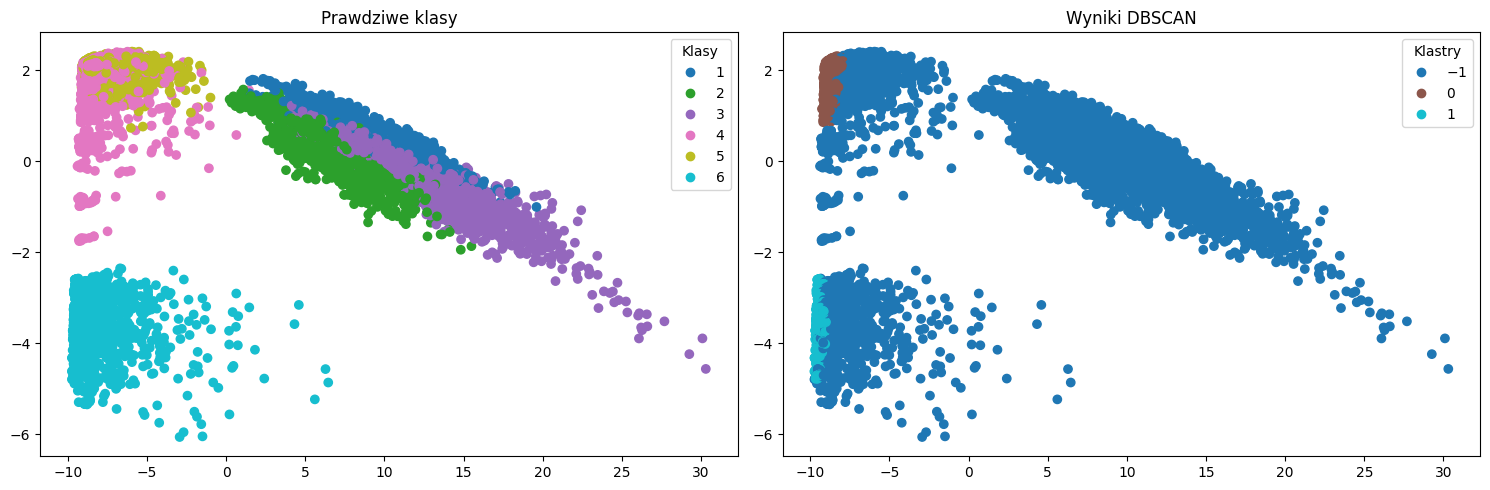

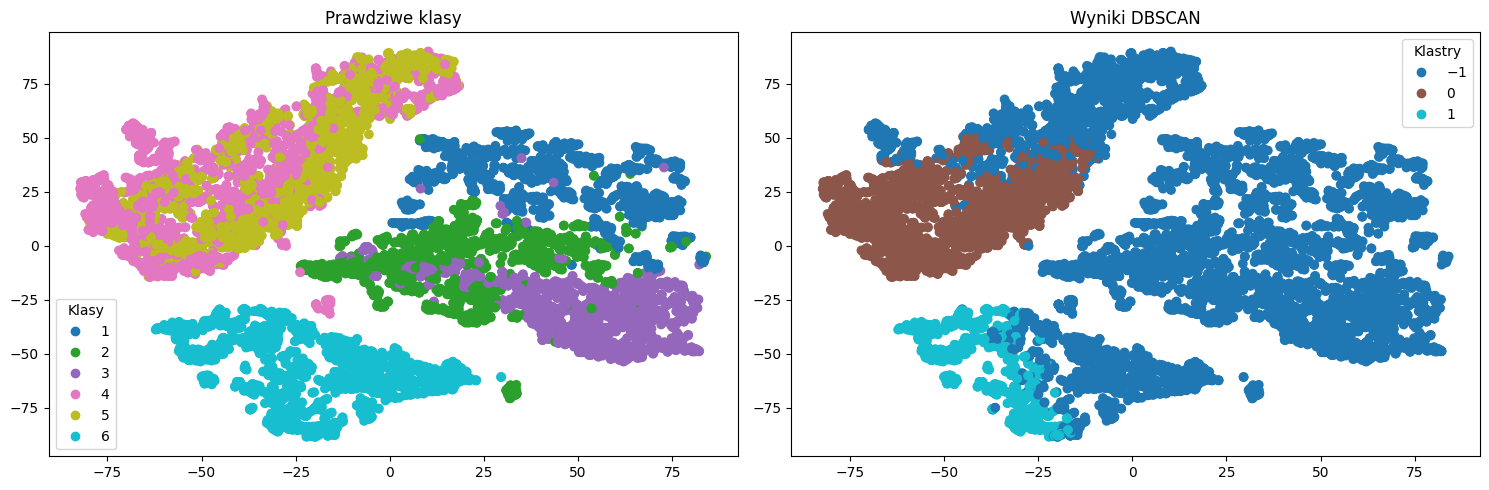

In [7]:
dbscan_labels, dbscan_silhouette, dbscan_ari = dbscan_analysis(X_scaled, y, eps=0.6, min_samples=125)
plot_clustering_results(X_pca, y, dbscan_labels, "DBSCAN")
plot_clustering_results(X_tsne, y, dbscan_labels, "DBSCAN")

## GMM

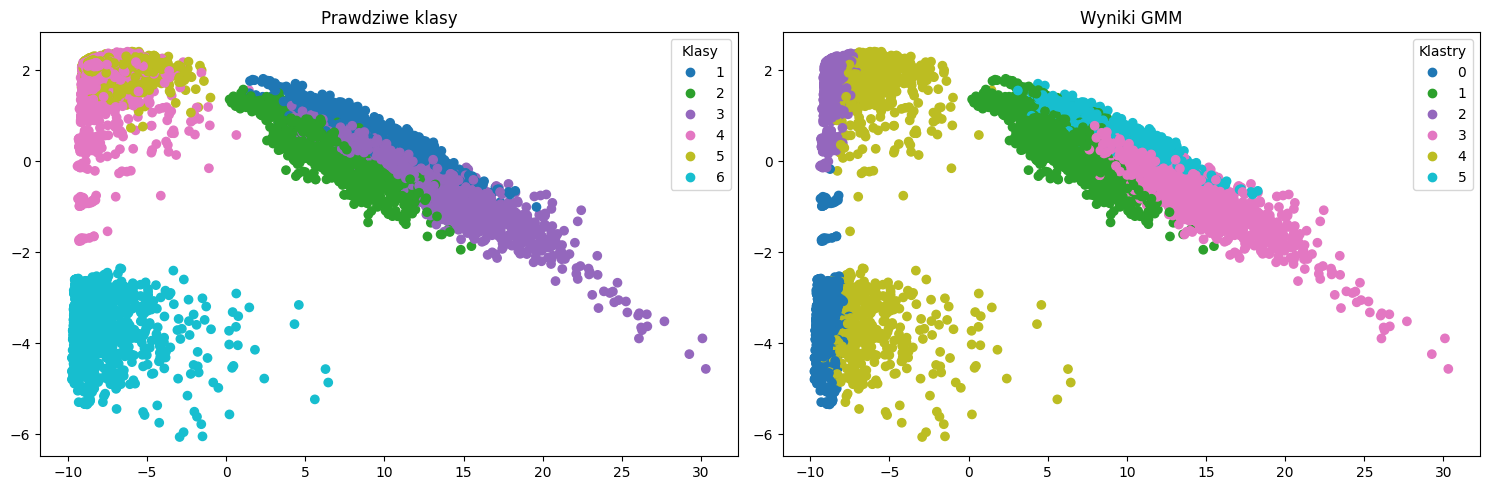

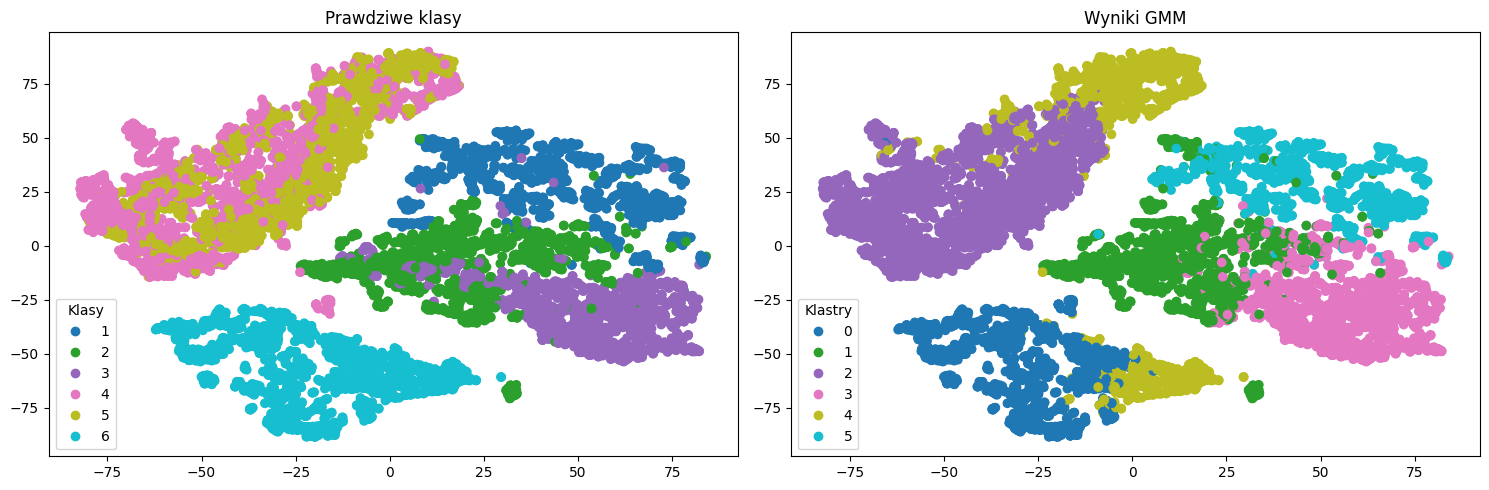

In [8]:
gmm = GaussianMixture(n_components=6, random_state=42, covariance_type='full', n_init=50)
labels_pred = gmm.fit_predict(X_scaled)
silhouette, ari = evaluate_clustering(X_scaled, y, labels_pred)

plot_clustering_results(X_pca, y, labels_pred, "GMM")
plot_clustering_results(X_tsne, y, labels_pred, "GMM")

In [9]:
print('silhouette', silhouette)
print('ari', ari)

silhouette 0.34906783157364357
ari 0.588340638973615


Analiza GMM:
Wizualizacja wyników GMM dla n_components = 6 (PCA)


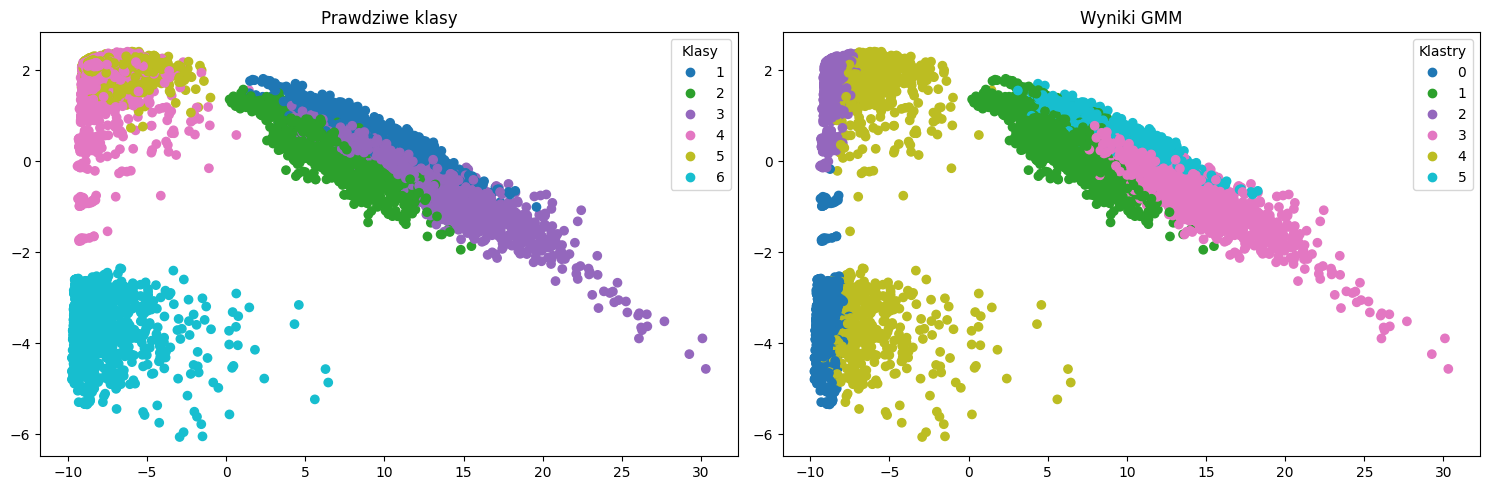

Wizualizacja wyników GMM dla n_components = 6 (T-SNE)


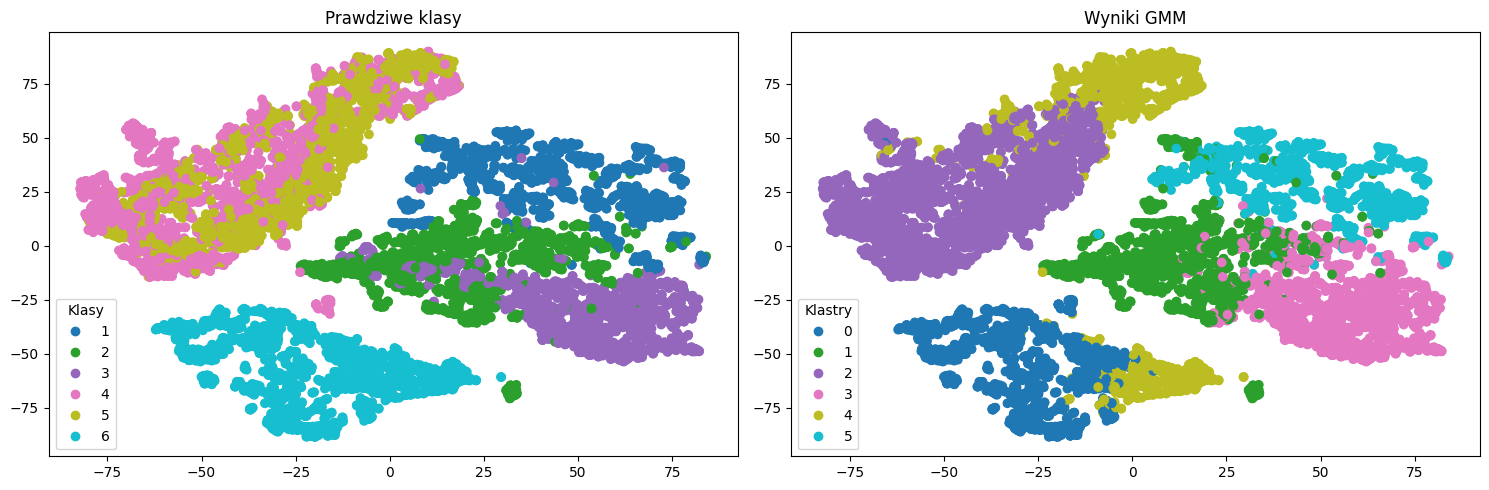

----------------------------------------------------------------------------------------------------


,n_components,silhouette,ari
0,6,0.349068,0.588341


In [11]:
n_components_values = [6]
results = []
print("Analiza GMM:")
for n_components in n_components_values:
    gmm_labels, gmm_silhouette, gmm_ari = gmm_analysis(X_scaled, y, n_components=n_components)
    results.append((n_components, gmm_silhouette, gmm_ari))
    print(f"Wizualizacja wyników GMM dla n_components = {n_components} (PCA)")
    plot_clustering_results(X_pca, y, gmm_labels, "GMM")
    print(f"Wizualizacja wyników GMM dla n_components = {n_components} (T-SNE)")
    plot_clustering_results(X_tsne, y, gmm_labels, "GMM")
    print("-"*100)

results_df = pd.DataFrame(results, columns=['n_components', 'silhouette', 'ari'])
results_df.sort_values(by='silhouette', ascending=False)
results_df

## Kfold

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Wczytanie danych
def load_data(file_path):
    return pd.read_csv(file_path, delim_whitespace=True, header=None)

# Wczytanie etykiet
def load_labels(file_path):
    return pd.read_csv(file_path, delim_whitespace=True, header=None)[0]

# Wczytanie danych treningowych i testowych
X_train = load_data('Samsung_HAR/samsung_HAR/samsung_train.txt')
y_train = load_labels('Samsung_HAR/samsung_HAR/samsung_train_labels.txt')
X_test = load_data('Samsung_HAR/samsung_HAR/samsung_test.txt')
y_test = load_labels('Samsung_HAR/samsung_HAR/samsung_test_labels.txt')

print("Kształt danych treningowych:", X_train.shape)
print("Kształt danych testowych:", X_test.shape)

# Preprocessing danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=50)  # Zredukujmy wymiarowość do 50 komponentów
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Przeprowadzenie klasteringu na zredukowanych danych
n_clusters = 6  # Liczba klas w oryginalnym zbiorze
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Dodanie wyników klasteringu jako nowych cech
X_train_with_clusters = np.column_stack((X_train_pca, train_clusters))
X_test_with_clusters = np.column_stack((X_test_pca, test_clusters))

# Funkcja do trenowania i oceny modelu z użyciem StratifiedKFold
def train_and_evaluate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = accuracy_score(y_fold_val, y_pred)
        scores.append(score)
        print(f"Fold {fold} - Accuracy: {score:.4f}")
    
    print(f"\nŚrednia dokładność: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return np.mean(scores)

# Trenowanie i ocena Random Forest
print("\nRandom Forest:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_score = train_and_evaluate_model(rf_model, X_train_with_clusters, y_train)

# Trenowanie i ocena SVM
print("\nSVM:")
svm_model = SVC(kernel='rbf', random_state=42)
svm_score = train_and_evaluate_model(svm_model, X_train_with_clusters, y_train)

C:\Users\wista\AppData\Local\Temp\ipykernel_11316\3938606318.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\wista\AppData\Local\Temp\ipykernel_11316\3938606318.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)[0]
C:\Users\wista\AppData\Local\Temp\ipykernel_11316\3938606318.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\wista\AppData\Local\Temp\ipykernel_11316\3938606318.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in

Kształt danych treningowych: (7352, 561)
Kształt danych testowych: (2947, 561)

Random Forest:
Fold 1 - Accuracy: 0.9327
Fold 2 - Accuracy: 0.9245
Fold 3 - Accuracy: 0.9238
Fold 4 - Accuracy: 0.9211
Fold 5 - Accuracy: 0.9156

Średnia dokładność: 0.9236 (+/- 0.0055)

SVM:
Fold 1 - Accuracy: 0.9456
Fold 2 - Accuracy: 0.9538
Fold 3 - Accuracy: 0.9531
Fold 4 - Accuracy: 0.9476
Fold 5 - Accuracy: 0.9456

Średnia dokładność: 0.9491 (+/- 0.0036)


Najlepiej poradził sobie Gaussian Mixture, potrafił ładnie oddzielić marsz, wchodzenie w górę i w dół po schodach. 

K-means natomiast najlepiej ocenił leżenie, też nieźle ocenił stanie i siedenie.

K-means służy do grupowania danych, należy do Unsupervised Learning.
K-fold służy do podziału danych i testowania modelu
KNN służy do klasyfikacji, należy do Supervised Learning